In [109]:

import os, time
from influxdb_client_3 import InfluxDBClient3, Point
import pandas as pd
from queryDSL import InfluxQueryBuilder, QueryAggregation, QueryFilter
import requests
import json

import matplotlib.pyplot as plt

In [110]:
import configparser

config = configparser.ConfigParser()
config.read('cacheConfig.ini')

influxConfig = config['influx']
token = influxConfig['token']
org = influxConfig['org']
host = influxConfig['host']

client = InfluxDBClient3(host=host, token=token, org=org)

In [111]:
currenttime = int(time.time())
previoustime = int(currenttime - 60)

# Convert to nanoseconds
currenttime_ns = currenttime * 1e9
previoustime_ns = previoustime * 1e9
print(currenttime_ns)
print(previoustime_ns)

1.71435011e+18
1.71435005e+18


- Build Queries
- Test runtime speed of queries against Cache for partial cache hits
- plot performance results
- correctness tests

## We want to show a few scenarios
1. Repeated queries with similar time ranges will use the cache and be faster
2. Queries asking for a different subset of measurements from the same table will use the cache and be faster
3. Issuing a query with a subset of group keys than a previous query will 
4. Issuing a query with a larger aggregation window than before will use the cache and be faster


My tests
- build out a few queries
- turn into json
- track time 
- use influx client to take actual direct query
- get cached version
- Use ipynb to keep track of results


In [77]:
'''
HOW TO WRITE TEST
- Only have to interact with testServer.py
- assume that testServer will return you a json version of a data frame
- try to learn how InfluxQueryBuilder maps out to a string
- buildInfluxQlStrI()
- buildJson()
- Track time difference
- plot the results
'''

# Repeated queries with similar time ranges will use the cache and be faster
query = """SELECT mean(value)
FROM "cpu_usage"
WHERE time > now() - 24h
GROUP BY time(1m), platform, host
"""

# Queries asking for a different subset of measurements from the same table will use the cache and be faster
query2 = f"""
SELECT mean(value)
FROM cpu_usage
WHERE platform = 'mac_os' OR platform = 'windows'
AND time < {format(currenttime_ns, '.0f')} AND time > {format(previoustime_ns, '.0f')}
GROUP BY time(5s),
host,platform

"""
'''
"""SELECT min(value), mean(value)
FROM "cpu_usage"
WHERE time > now() - 24h
GROUP BY time(1m), platform, host
"""
'''

# Issuing a query with a subset of group keys than a previous query will use the cache and be faster
query3 = """SELECT max(value)
FROM "cpu_usage"
WHERE time > now() - 24h
GROUP BY time(1m), platform
"""

# Issuing a query with a larger aggregation window than before will use the cache and be faster
query4 = """SELECT mean(value)
FROM "cpu_usage"
WHERE time > now() - 48h
GROUP BY time(5m), platform, host
"""


In [128]:
# BUILD QUERIES --> JSON

# Query 1
influxBuilder = (InfluxQueryBuilder()
               .withBucket("Test")
               .withMeasurements(["value"])
               .withTable("cpu_usage")
               .withFilter(QueryFilter("platform", "mac_os").OR(QueryFilter("platform", "windows")))
               .withAggregate(QueryAggregation("10m", "mean", False))
               .withRelativeRange('30m', None)
               .withGroupKeys(["host", "platform"])
       )

influxBuilderReGrouped = (InfluxQueryBuilder()
               .withBucket("Test")
               .withMeasurements(["value"])
               .withTable("cpu_usage")
               .withFilter(QueryFilter("platform", "mac_os").OR(QueryFilter("platform", "windows")))
               .withAggregate(QueryAggregation("20m", "mean", False))
               .withRelativeRange('30m', None)
               .withGroupKeys(["platform"])
       )

queryStr = influxBuilder.buildInfluxQlStr()
queryJson = influxBuilder.buildJson()

# Query 2 -  Queries asking for a different subset of measurements from the same table will use the cache and be faster
influxBuilder2 = (InfluxQueryBuilder()
               .withBucket("Test")
               .withMeasurements(["value"])
               .withTable("cpu_usage")
               .withFilter(QueryFilter("platform", "mac_os"))
               .withAggregate(QueryAggregation("20m", "max", False))
               .withRelativeRange('30m', None)
               .withGroupKeys(["host", "platform"])
       )

queryStr2 = influxBuilder2.buildInfluxQlStr()
queryJson2 = influxBuilder2.buildJson()


In [131]:
cacheUrlJson = "http://127.0.0.1:5000/api/query"
requests.post("http://localhost:5000/api/reset")
print("Running Query 2: %s" % queryStr2)
startTime = time.time()
table = client.query(query=queryStr2, database="Test", language="influxql", mode='pandas')
print(table)
rawLatency = time.time() - startTime

# Execute via cache service
startTime = time.time()
cachedTableResp = requests.post(cacheUrlJson, json=queryJson2)
print(cachedTableResp)

cacheLatency = time.time() - startTime

cachedTableJson = cachedTableResp.json()
cachedTableDf = pd.read_json(json.dumps(cachedTableJson), orient='records')

print(cachedTableDf)

print("Raw query took %.2f seconds" % rawLatency)
print("Cache query took %.2f seconds" % cacheLatency)

Running Query 2: SELECT max(value)
FROM cpu_usage
WHERE platform = 'mac_os'
AND time > 1714348815000000000 AND time < 1714350615000000000
GROUP BY time(20m), host,platform

  iox::measurement                time   host platform         max
0        cpu_usage 2024-04-29 00:00:00  host1   mac_os  100.000000
1        cpu_usage 2024-04-29 00:20:00  host1   mac_os   42.900000
2        cpu_usage 2024-04-29 00:00:00  host2   mac_os  108.364618
3        cpu_usage 2024-04-29 00:20:00  host2   mac_os  113.136458
<Response [200]>
            time iox::measurement   host platform   max_value
0  1714347600000        cpu_usage  host1   mac_os   30.600000
1  1714348800000        cpu_usage  host1   mac_os  100.000000
2  1714350000000        cpu_usage  host1   mac_os   42.900000
3  1714347600000        cpu_usage  host2   mac_os   19.358491
4  1714348800000        cpu_usage  host2   mac_os  116.940278
5  1714350000000        cpu_usage  host2   mac_os  113.136458
Raw query took 0.14 seconds
Cache query t

/var/folders/28/6m241wg91ls0cqk0nmt_s2880000gn/T/ipykernel_94083/2433937836.py:17: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  cachedTableDf = pd.read_json(json.dumps(cachedTableJson), orient='records')


In [103]:
requests.post("http://localhost:5000/api/reset")
print("Running query 1 %s" % queryStr)
# Execute the query via client
startTime = time.time()
table2 = client.query(query=queryStr, database="Test", language="influxql", mode='pandas')
print(table2)
rawLatency = time.time() - startTime

# Execute the query via cache service
startTime = time.time()

print(queryJson)
cachedTableResp = requests.post(cacheUrlJson, json=queryJson)
print(cachedTableResp)

cacheLatency = time.time() - startTime

cachedTableJson = cachedTableResp.json()
cachedTableDf = pd.read_json(json.dumps(cachedTableJson), orient='records')

print(cachedTableDf)

print("Raw query took %.2f seconds" % rawLatency)
print("Cache query took %.2f seconds" % cacheLatency)


Running query 1 SELECT mean(value)
FROM cpu_usage
WHERE platform = 'mac_os' OR platform = 'windows'
AND time > 1714348003000000000 AND time < 1714349803000000000
GROUP BY time(10m), host,platform

   iox::measurement                time   host platform       mean
0         cpu_usage 2024-04-28 23:40:00  host1   mac_os        NaN
1         cpu_usage 2024-04-28 23:50:00  host1   mac_os  26.859184
2         cpu_usage 2024-04-29 00:00:00  host1   mac_os  25.101866
3         cpu_usage 2024-04-29 00:10:00  host1   mac_os  25.003226
4         cpu_usage 2024-04-28 23:40:00  host1  windows        NaN
5         cpu_usage 2024-04-28 23:50:00  host1  windows   3.202787
6         cpu_usage 2024-04-29 00:00:00  host1  windows   4.301744
7         cpu_usage 2024-04-29 00:10:00  host1  windows  -0.338423
8         cpu_usage 2024-04-28 23:40:00  host2   mac_os        NaN
9         cpu_usage 2024-04-28 23:50:00  host2   mac_os   3.875965
10        cpu_usage 2024-04-29 00:00:00  host2   mac_os   2.408611

/var/folders/28/6m241wg91ls0cqk0nmt_s2880000gn/T/ipykernel_94083/166781479.py:20: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  cachedTableDf = pd.read_json(json.dumps(cachedTableJson), orient='records')


In [104]:
# test multiple times
runs = 20
delay = 1
rawLatencies = []
cachedLatecies = []
cacheUrlJson = "http://127.0.0.1:5000/api/query"
requests.post("http://localhost:5000/api/reset")

for i in range(runs):
    startTime = time.time()
    table = client.query(query=queryStr, database="Test", language="influxql", mode='pandas')
    rawLatency = time.time() - startTime
    rawLatencies.append(rawLatency)
    # print("Raw Latency: %s" % rawLatency)

    startTime = time.time()
    cachedTableResp = requests.post(cacheUrlJson, json=queryJson)
    cachedLatency = time.time() - startTime
    cachedLatecies.append(cachedLatency)
    # print("Cached Latency: %s" % cachedLatency)

    time.sleep(delay)


print("Without cache: avg", sum(rawLatencies)/len(rawLatencies), "seconds")
print("With cache: avg", sum(cachedLatecies)/len(cachedLatecies), "seconds")

Without cache: avg 0.08613533973693847 seconds
With cache: avg 0.017164397239685058 seconds


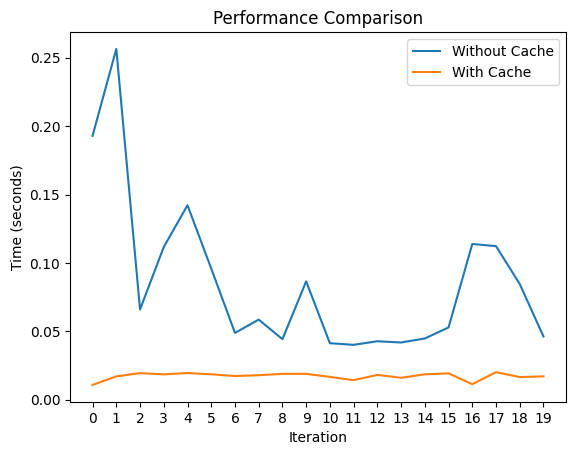

In [106]:
plt.plot(rawLatencies, label='Without Cache')
plt.plot(cachedLatecies, label='With Cache')
plt.xlabel('Iteration')
plt.ylabel('Time (seconds)')
plt.title('Performance Comparison')
plt.legend()

# Set the step for the x-axis to 1
plt.xticks(range(len(rawLatencies)), range(len(rawLatencies)))
plt.show()

Text(0.5, 1.0, 'Average Performance Comparison')

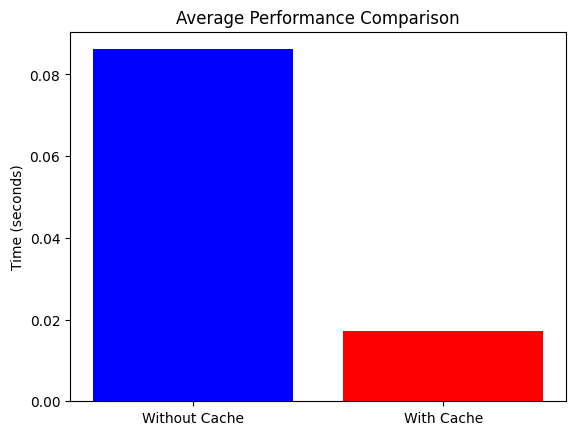

In [107]:
# Plot bar graph comparing the averages
plt.bar(['Without Cache', 'With Cache'], 
    [sum(rawLatencies)/len(rawLatencies), sum(cachedLatecies)/len(cachedLatecies)], color=['blue', 'red'])
plt.ylabel('Time (seconds)')
plt.title('Average Performance Comparison')


In [108]:
print("Trying regrouping")
regroupRequestJson = influxBuilderReGrouped.buildJson()
startTime = time.time()
print(startTime)
print(regroupRequestJson)
regroupResp = requests.post(cacheUrlJson, json=regroupRequestJson).json()

print(regroupResp)
regroupLatency = time.time() - startTime

regroupedTableDf = pd.read_json(json.dumps(regroupResp), orient='records')
print(regroupedTableDf)
print("Regroup query took %.2f seconds" % regroupLatency)


Trying regrouping
1714349874.951824
{'bucket': 'Test', 'range': {'start': 1714348074, 'end': 1714349874}, 'relativeRange': {'fr': '30m', 'to': None}, 'filters': [{'filter': [{'key': 'platform', 'value': 'mac_os', 'type': 'raw'}, {'key': 'platform', 'value': 'windows', 'type': 'raw'}], 'type': 'or'}], 'yield': '', 'measurements': ['value'], 'table': 'cpu_usage', 'groupKeys': ['platform'], 'aggregate': {'timeWindow': '20m', 'aggFunc': 'mean', 'createEmpty': False}}
{'time': {'0': 1714346400000, '1': 1714347600000, '2': 1714348800000, '3': 1714346400000, '4': 1714347600000, '5': 1714348800000}, 'iox::measurement': {'0': 'cpu_usage', '1': 'cpu_usage', '2': 'cpu_usage', '3': 'cpu_usage', '4': 'cpu_usage', '5': 'cpu_usage'}, 'platform': {'0': 'mac_os', '1': 'mac_os', '2': 'mac_os', '3': 'windows', '4': 'windows', '5': 'windows'}, 'mean_value': {'0': None, '1': 14.6514600119, '2': 13.7552383716, '3': None, '4': 9.4137855356, '5': 8.815285244}}
            time iox::measurement platform  mean_

/var/folders/28/6m241wg91ls0cqk0nmt_s2880000gn/T/ipykernel_94083/3867237047.py:11: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  regroupedTableDf = pd.read_json(json.dumps(regroupResp), orient='records')
